In [1]:
import numpy as np
from scipy.fft import fft, fftshift, ifft, ifftshift
import plotly.express as xp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pywt
import cv2 as cv
from tqdm import tqdm
import os

In [2]:
MISSING_PIXEL_PATH = './dataset/missing_pixel/'
ORIGINAL_IMAGE_PATH = './dataset/original_image/'
LIST_IMAGE = next(os.walk(ORIGINAL_IMAGE_PATH), (None, None, []))[2]

In [3]:
def soft_thresh(x, lam):
    if ~(isinstance(x[0], complex)):
        return np.zeros(x.shape) + (x + lam) * (x<-lam) + (x - lam) * (x>lam) 
    else:
        return np.zeros(x.shape) + ( abs(x) - lam ) / abs(x) * x * (abs(x)>lam) 

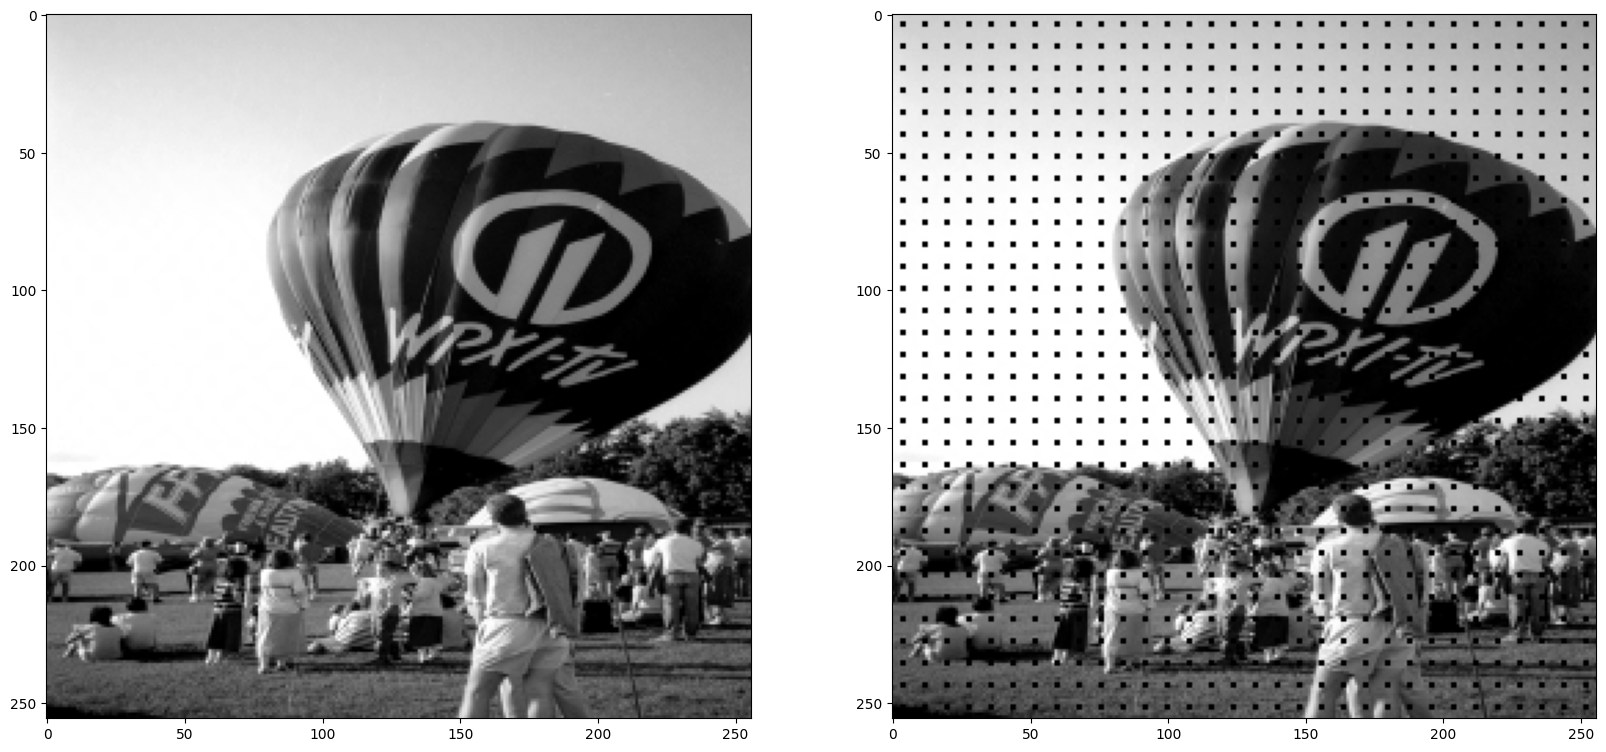

In [13]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(original, cmap=plt.cm.gray)
ax[1].imshow(missing,cmap=plt.cm.gray)

In [5]:
def flat_wavelet_transform2(x, method='bior1.3'):
    """For a 2D image x, take the wavelet """
    coeffs = pywt.wavedec2( x, method )
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

def inverse_flat_wavelet_transform2(X,  shape, method='bior1.3'):
    shapes = pywt.wavedecn_shapes( shape , method)
    nx = shapes[0][0]
    ny = shapes[0][1]
    n = nx * ny
    coeffs = [X[:n].reshape(nx,ny) ]
    for i, d in enumerate(shapes[1:]):
        vals=list(d.values())
        nx = vals[0][0]
        ny = vals[0][1]
        coeffs.append( (X[ n : n + nx * ny].reshape( nx, ny ), 
                        X[ n + nx * ny : n + 2 * nx * ny ].reshape( nx, ny ), 
                        X[ n + 2 * nx * ny : n + 3 * nx * ny ].reshape( nx, ny ))  )
        n += 3 * nx * ny
    return pywt.waverec2(coeffs, method)

In [21]:
methods = ['haar','coif1','coif2','coif3','bior1.1','bior1.3','bior3.1','bior3.3','rbio1.1','rbio1.3','rbio3.1','rbio3.3']
def distance(x,y):
    # return sum(abs(x.reshape(-1)-y.reshape(-1)))
    return ((x - y) ** 2).mean()

# undersampled noisy signal in image-space and let this be first order Xhat


# Repeat steps 1-4 until change is below a threshold
eps = 1e-8
lam_decay = 0.995
minlam = 1

tot_err = []
for img_fname in LIST_IMAGE:
    original = cv.imread(ORIGINAL_IMAGE_PATH + img_fname, cv.IMREAD_GRAYSCALE)
    original = cv.resize(original, (256, 256), cv.INTER_CUBIC)
    original = original.astype(np.float64)

    missing = cv.imread(MISSING_PIXEL_PATH + img_fname[:-3] + '.jpg', cv.IMREAD_GRAYSCALE)
    err2=[]

    y = missing

    lam = 100

    xhat = y.copy()
    for i in tqdm(range(516)):
        method = 'sym17'
        xhat_old = xhat
        Xhat_old = flat_wavelet_transform2(xhat, method)
        Xhat = soft_thresh(Xhat_old, lam)
        xhat = inverse_flat_wavelet_transform2(Xhat, (256,256), method)
        xhat[y!=0] = y[y!=0]   


        xhat = xhat.astype(int)
        xhat[xhat<0] = 0
        xhat[xhat>255] = 255
        err2.append(distance(original, xhat))
        lam *= lam_decay

    tot_err.append(np.min(err2))

    
# fig = plt.figure(figsize=(10,10))  
# plt.loglog(err2)


# fig,ax = plt.subplots(1,2,figsize=(20,10))
# ax[0].imshow(original, cmap=plt.cm.gray)
# ax[1].imshow(abs(xhat - original),cmap=plt.cm.gray, vmin=0, vmax=255)

100%|██████████| 516/516 [00:03<00:00, 167.93it/s]


In [23]:
np.mean(tot_err)

44.98048123446378